## Name: Jaskirat Singh Maskeen (23110146)
## Under supervision of: Prof. Sandip Lashkare
---
### Parameters:
```
training_images_amount:        400
testing_images_amount:         100
training_duration:             350
past_window:                   -10
epochs:                        5
image_size:                    [28, 28]
resting_potential:             -70
input_layer_size:              784
output_layer_size:             320
inhibitory_potential:          -100
spike_threshold:               -55
reset_potential:               -90
spike_drop_rate:               0.8
threshold_drop_rate:           0.4
min_weight:                    1e-05
max_weight:                    1.0
A_up:                          0.8
A_down:                        -0.3
tau_up:                        5
tau_down:                      5
eta:                           0.01
min_frequency:                 1
max_frequency:                 50
refractory_time:               15
tau_m:                         10
conductance:                   10
```
### Accuracy Obtained on 2000 new images (trained on 400 images):
<b>76.5%<b>

## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json
from IPython.display import HTML
import matplotlib.animation as animation
import time
import tensorflow as tf
import os
import seaborn as sns
from collections import defaultdict
import requests


### Helper functions

In [ ]:
if not os.path.exists('Good Values'):
  os.mkdir('Good Values')
if not os.path.exists(r'Good Values/81'):
  os.mkdir('Good Values/81')

with open('Good Values/81/labels.csv','w') as f:
  f.write(requests.get('https://pastebin.com/raw/ZgEZaKNr').text)

with open('Good Values/81/synapses.csv','w') as f:
  f.write(requests.get('https://gist.githubusercontent.com/jsmaskeen/aa8610bd6b67d53a8131b40a11ac1b5c/raw/c8c70e6a227fc0e52aad948fdaaaab668587acd8/synapses.csv').text)


In [ ]:
def animator(data, fig, ax, num_steps=None, interval=40, cmap="plasma"):
    if num_steps is None:
        num_steps = data.shape[0]
    data = data.cpu().numpy()
    im = ax.imshow(data[0], cmap=cmap, vmin=data.min(), vmax=data.max())
    ax.axis("off")
    def update(frame):
        im.set_array(data[frame])
        return [im]
    anim = animation.FuncAnimation(
        fig, update, frames=num_steps, interval=interval, blit=True
    )
    return anim

def reshape_to_tensor(spike_train,time_dim):
    if not isinstance(spike_train, tf.Tensor):
        spike_train = tf.convert_to_tensor(spike_train)
    reshaped_tensor = tf.reshape(spike_train, (time_dim, 28, 28))
    return reshaped_tensor


## Parameters

In [ ]:
class Params:
    def __init__(self):
        print('Loading Parameters')
        if os.path.exists("parameters.json"):
            params = json.load(open("parameters.json"))
        else:
            params = requests.get('https://pastebin.com/raw/7F4wUc0D').json()
            with open('parameters.json','w') as f:
              f.write(json.dumps(params,indent=4))
        for k, v in params.items():
            setattr(self, k, v)
for k,v in Params().__dict__.items():
  print(f"{k}:{' '*(30-len(k))}{v}")

Loading Parameters
training_images_amount:        400
testing_images_amount:         100
training_duration:             350
past_window:                   -10
epochs:                        5
image_size:                    [28, 28]
resting_potential:             -70
input_layer_size:              784
output_layer_size:             320
inhibitory_potential:          -100
spike_threshold:               -55
reset_potential:               -90
spike_drop_rate:               0.8
threshold_drop_rate:           0.4
min_weight:                    1e-05
max_weight:                    1.0
A_up:                          0.8
A_down:                        -0.3
tau_up:                        5
tau_down:                      5
eta:                           0.01
min_frequency:                 1
max_frequency:                 50
refractory_time:               15
tau_m:                         10
conductance:                   10


## Leaky Integrate and Fire Neuron

Loading Parameters


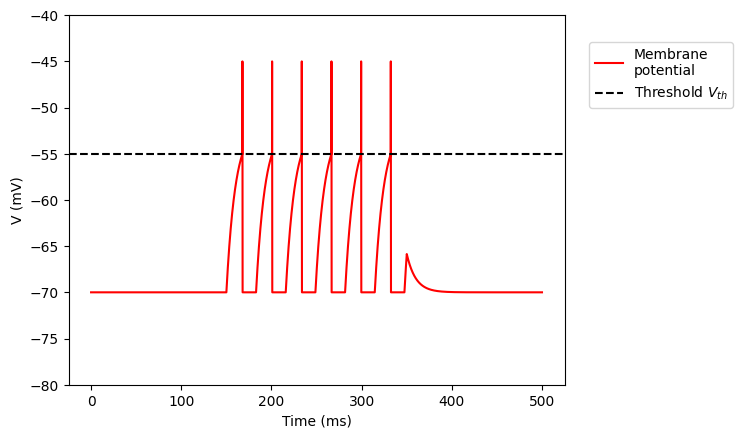

In [ ]:
class LIFNeuron:
    def __init__(self, params):
        self.params = params
        self.adaptive_threshold = None
        self.reftactory_time = None
        self.potential = None
        self.rest_until = None
        self.initial()

    def state_just_after_firing(self, time_step):
        self.potential = self.params.reset_potential
        self.rest_until = time_step + self.reftactory_time

    def inhibit(self, time_step):
        self.potential = self.params.inhibitory_potential
        self.rest_until = time_step + self.reftactory_time

    def initial(self):
        self.adaptive_threshold = self.params.spike_threshold
        self.rest_until = -1
        self.reftactory_time = self.params.refractory_time
        self.potential = self.params.resting_potential


class ExampleCurrentThroughLIFNeuron:
    def __init__(self, params):
        self.params = params
        self.neuron = LIFNeuron(params)
        self.dt = 0.1
        self.simulation_duration = 500
        self.clock = np.arange(0, self.simulation_duration, self.dt)

    def simulate_pulse(self, current_magnitude):
        V = np.zeros(self.clock.size)
        V[0] = self.params.resting_potential
        I = current_magnitude * np.ones(self.clock.size)
        I[: int(self.clock.size // 2 - 1e3)] = 0
        I[int(self.clock.size // 2 + 1e3) :] = 0

        spike_time_index = []
        refractory_counter = 0

        for time_step in range(self.clock.size - 1):
            if refractory_counter > 0:
                V[time_step] = self.params.resting_potential
                refractory_counter -= 1
            elif V[time_step] >= self.params.spike_threshold:
                spike_time_index.append(time_step)
                V[time_step] = self.params.resting_potential
                refractory_counter = self.params.refractory_time / self.dt

            dV = (
                (
                    -(V[time_step] - self.params.resting_potential)
                    + I[time_step] / self.params.conductance
                )
                * self.dt
                / self.params.tau_m
            )
            V[time_step + 1] = V[time_step] + dV

        if len(spike_time_index) > 0:
            V[np.array(spike_time_index) - 1] += 10

        plt.plot(self.clock, V, "r", label="Membrane\npotential")
        plt.axhline(
            self.params.spike_threshold,
            0,
            1,
            color="k",
            ls="--",
            label="Threshold $V_{th}$",
        )
        plt.xlabel("Time (ms)")
        plt.ylabel("V (mV)")
        plt.legend(loc=[1.05, 0.75])
        plt.ylim([-80, -40])
        plt.show()


sim = ExampleCurrentThroughLIFNeuron(Params())
sim.simulate_pulse(180)

## Encoding input images
<video width=600 controls>
      <source src="https://files.catbox.moe/kfq33w.mp4" >
</video>

Loading Parameters
Loading Raw Data
Label = 7


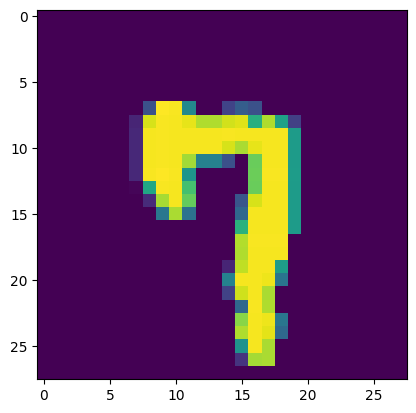

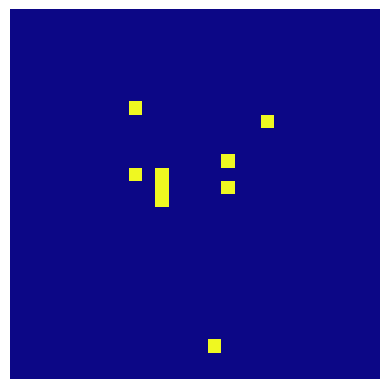

In [ ]:

class MNISTProcesser:
    def __init__(self, params):
        self.params = params
        print('Loading Raw Data')
        (self.X_train, self.Y_train), (self.X_test, self.Y_test) = tf.keras.datasets.mnist.load_data()


    def normalise(self, img: np.ndarray):
        return (img - np.min(img)) / (np.max(img) - np.min(img))

    def img2spiketrain(self, img: np.ndarray):
        sx, sy = img.shape
        time_steps = self.params.training_duration + 1
        normalized_img = self.normalise(img)
        frequencies = normalized_img * (self.params.max_frequency - self.params.min_frequency) + self.params.min_frequency
        intervals = np.ceil(self.params.training_duration / frequencies).astype(int)
        spike_trains = np.zeros((sx, sy, time_steps), dtype=int)

        for t in range(1, time_steps):
            spikes = (t % intervals == 0) & (img > 0) #spike condition
            spike_trains[:, :, t] = spikes.astype(int)

        return spike_trains.reshape(-1, time_steps)

    def get_random_image(self,get_spike_train=False):
        idx = np.random.randint(0,len(self.X_train))
        X = self.X_train[idx]
        Y = self.Y_train[idx]
        spike_train = None
        if get_spike_train:
            spike_train = self.img2spiketrain(X)
        return X,Y,spike_train

    def load_balanced_mnist(self, Y, num_samples, seed=None):
        rng = np.random.default_rng(seed)
        unique_labels = np.unique(Y)
        samples_per_label = num_samples // len(unique_labels)
        selected_indices = []

        for label in unique_labels:
            indices = np.where(Y == label)[0]
            selected_indices.extend(rng.choice(indices, size=samples_per_label, replace=False))

        selected_indices = rng.permutation(selected_indices)
        return selected_indices

    def dataloader(self,train=True,preprocess=False,random_single=False,seed=42,size=None):
        if not random_single:
            fin_X = []
            fin_Y = []
            print(f"Loading{' preprocessed' if preprocess else ''} {'train' if train else 'test'} data")
            if train:
                if not size:
                    size = self.params.training_images_amount
                indices = self.load_balanced_mnist(self.Y_train,size,seed=seed)
                X,Y = self.X_train[indices],self.Y_train[indices]
            else:
                if not size:
                    size = self.params.testing_images_amount
                indices =  self.load_balanced_mnist(self.Y_test,size,seed=seed)
                X,Y = self.X_test[indices],self.Y_test[indices]

            for img,label in zip(X,Y):
                if preprocess:
                    img = self.img2spiketrain(img)
                fin_X.append(img)
                fin_Y.append(label)

            return np.array(fin_X),np.array(fin_Y)
        idx = np.random.choice(range(len(self.X_train)))
        if preprocess:
            return self.X_train[idx],self.img2spiketrain(self.X_train[idx]),self.Y_train[idx]
        return self.X_train[idx],self.X_train[idx],self.Y_train[idx]

m = MNISTProcesser(Params())
x,y,spike_train = m.get_random_image(True)
print(f'Label = {y}')
plt.imshow(x)
plt.show()
spike_train_tensor = reshape_to_tensor(spike_train.T,spike_train.shape[1])
animate = True
if animate:
    fig,ax = plt.subplots()
    anim = animator(spike_train_tensor, fig, ax)
    display(HTML(anim.to_html5_video()))

## MNSIT SNN

In [ ]:
class MNIST_SNN:
    def __init__(self, params,visualise=False):
        self.params = params
        self.t0 = time.time()
        self.str_t0 = time.strftime("%Y_%m_%d-%H_%M_%S")
        self.dataloader = MNISTProcesser(self.params)
        self.X_train_processed, self.Y_train_processed = self.dataloader.dataloader(
            preprocess=True
        )
        self.X_test_processed, self.Y_test_processed = self.dataloader.dataloader(
            train=False, preprocess=True
        )
        self.train_set_processed = list(
            zip(self.X_train_processed, self.Y_train_processed)
        )
        self.test_set_processed = list(
            zip(self.X_test_processed, self.Y_test_processed)
        )
        self.master_memory = [] # [list of epochs] each epoch contains
        self.visualise = visualise

    def update_current_potentials_and_adaptive_thresholds(
        self, current_potentials, neuron, neuron_index, spike_train, synapses, time_step
    ):
        if neuron.rest_until < time_step:
            neuron.potential += np.dot(
                synapses[neuron_index], spike_train[:, time_step]
            )

            if neuron.potential > self.params.resting_potential:
                neuron.potential -= self.params.spike_drop_rate
                if neuron.adaptive_threshold > self.params.spike_threshold:
                    neuron.adaptive_threshold -= self.params.threshold_drop_rate

            current_potentials[neuron_index] = neuron.potential

    def reweigh_synapses_for_single_input_neuron_and_highest_potential_neuron(
        self,
        input_layer_idx,
        spike_train,
        synapses,
        time_step,
        highest_potetnial_neuron_idx,
        synapse_memory,
    ):
        for dt in range(0, self.params.past_window - 1, -1):  # in past timeframe
            if 0 <= time_step + dt < self.params.training_duration + 1:
                if spike_train[input_layer_idx][time_step + dt] == 1:  # if pre before post
                    synapses[highest_potetnial_neuron_idx][input_layer_idx] = self.update_synapse(
                        synapses[highest_potetnial_neuron_idx][input_layer_idx],
                        self.STDP_curve(dt),
                    )
                    synapse_memory[highest_potetnial_neuron_idx][input_layer_idx] = 1
        if (
            synapse_memory[highest_potetnial_neuron_idx][input_layer_idx] != 1
        ):  # if pre not before post in the past timeframe
            synapses[highest_potetnial_neuron_idx][input_layer_idx] = self.update_synapse(
                synapses[highest_potetnial_neuron_idx][input_layer_idx],
                self.STDP_curve(
                    np.random.choice(list(range(1, abs(self.params.past_window) // 2)))
                ),
            )  # np.random.choice(list(range(1,abs(self.params.past_window)//2)))

    def update_synapse(self, synapse_weight, weight_factor):
        diff = (
            (synapse_weight - self.params.min_weight)
            if weight_factor < 0
            else (self.params.max_weight - synapse_weight)
        )
        return (
            synapse_weight + self.params.eta * weight_factor * (diff) ** 0.9
        )  # https://sci-hub.se/https://ieeexplore.ieee.org/abstract/document/8983810

    def STDP_curve(self, delta_t: int):
        if delta_t > 0:
            return self.params.A_down * (np.exp(-float(delta_t) / self.params.tau_down))
        else:  # delta_t <=0
            return self.params.A_up * (np.exp(float(delta_t) / self.params.tau_up))

    def plot_stdp_curve(self):
        time_arr= np.linspace(-5 * self.params.tau_up, 5 * self.params.tau_down, 50)
        delta_w = np.array([self.STDP_curve(i) for i in time_arr])
        plt.figure()
        plt.plot([-5 * self.params.tau_up, 5 * self.params.tau_down], [0, 0], 'k', linestyle=':')
        plt.plot([0, 0], [np.min(delta_w), (np.max(delta_w))], 'k', linestyle=':')

        plt.plot(time_arr[time_arr <= 0], delta_w[time_arr <= 0], 'ro')
        plt.plot(time_arr[time_arr > 0], delta_w[time_arr > 0], 'bo')
        plt.grid()
        plt.xlabel(r'$t_{pre} - t_{post}$ (ms)')
        plt.ylabel(r'$\Delta$w')
        plt.title('STDP curve')
        plt.ylim(-0.6,0.9)
        plt.show()

    def save_epoch(self, epoch, synapses, neuron_label_map):
        if not os.path.exists(f"storage"):
            os.mkdir(f"storage")
        if not os.path.exists(f"storage/{self.str_t0}"):
            os.mkdir(f"storage/{self.str_t0}")
        if not os.path.exists(f"storage/{self.str_t0}/Epoch_{epoch}"):
            os.mkdir(f"storage/{self.str_t0}/Epoch_{epoch}")

        weights_path = f"storage/{self.str_t0}/Epoch_{epoch}/synapses.csv"
        labels_path = f"storage/{self.str_t0}/Epoch_{epoch}/labels.csv"

        np.savetxt(weights_path, synapses, delimiter=",")
        np.savetxt(labels_path, neuron_label_map, delimiter=",")

    def feed_forward(self, spike_train, synapses, neuron_label_map, training_duration, do_stdp=False, label=None,visu=True):
        output_layer = [LIFNeuron(self.params) for _ in range(self.params.output_layer_size)]
        count_spikes_for_output_layer = np.zeros(self.params.output_layer_size)
        current_potentials_for_output_layer = np.zeros(self.params.output_layer_size)
        synapse_memory = np.zeros((self.params.output_layer_size, self.params.input_layer_size))
        if self.visualise:
            syn_ls = []
        for time_step in training_duration:
            for neuron_index, neuron in enumerate(output_layer):
                self.update_current_potentials_and_adaptive_thresholds(
                    current_potentials_for_output_layer,
                    neuron,
                    neuron_index,
                    spike_train,
                    synapses,
                    time_step,
                )

            highest_potetnial_neuron_idx = np.argmax(current_potentials_for_output_layer)
            highest_potential_neuron = output_layer[highest_potetnial_neuron_idx]

            if current_potentials_for_output_layer[highest_potetnial_neuron_idx] < highest_potential_neuron.adaptive_threshold:
                continue

            count_spikes_for_output_layer[highest_potetnial_neuron_idx] += 1
            highest_potential_neuron.state_just_after_firing(time_step)
            highest_potential_neuron.adaptive_threshold += 1

            if do_stdp:
                for input_layer_idx in range(self.params.input_layer_size):
                    self.reweigh_synapses_for_single_input_neuron_and_highest_potential_neuron(
                        input_layer_idx,
                        spike_train,
                        synapses,
                        time_step,
                        highest_potetnial_neuron_idx,
                        synapse_memory,
                    )
                if self.visualise and visu:
                    syn_ls.append((time_step,synapses[highest_potetnial_neuron_idx]))

            for nidx, neuron in enumerate(output_layer):
                if nidx != highest_potetnial_neuron_idx:
                    if neuron.potential > neuron.adaptive_threshold:
                        count_spikes_for_output_layer[nidx] += 1
                    neuron.inhibit(time_step)

        for neuron in output_layer:
            neuron.initial()

        if do_stdp and label is not None:
            neuron_label_map[highest_potetnial_neuron_idx] = int(label)
            if self.visualise and visu:
                    self.vis_ls.append((int(label),syn_ls))

        return count_spikes_for_output_layer, highest_potetnial_neuron_idx

    def train(self):
        print("Training Started")
        self.t0 = time.time()

        synapses = np.ones((self.params.output_layer_size, self.params.input_layer_size))
        neuron_label_map = np.repeat(-1, self.params.output_layer_size)
        training_duration = np.arange(1, self.params.training_duration + 1, 1)
        test_accuracy_over_epochs = []
        for epoch in range(self.params.epochs):
            print(f"Epoch {epoch + 1}/{self.params.epochs}")
            cnt = 0
            if self.visualise:
                self.vis_ls = []

            for spike_train, label in self.train_set_processed:
                cnt += 1
                self.feed_forward(
                    spike_train, synapses, neuron_label_map, training_duration, do_stdp=True, label=label
                )

                bar_length = 40
                progress = int(bar_length * cnt / self.params.training_images_amount)
                bar = '=' * progress + '.' * (bar_length - progress)
                print(f"\r{str(cnt).zfill(len(str(self.params.training_images_amount)))}/{self.params.training_images_amount} [{bar}]", end='')

            if self.visualise:
                self.master_memory.append(self.vis_ls)


            self.learned_synapses = synapses
            self.learned_neuron_label_map = neuron_label_map
            print('\nTesting...')
            test_accuracy = self.test()
            test_accuracy_over_epochs.append(test_accuracy)
            print(f'\rTest set accuracy: {round(test_accuracy, 3) if test_accuracy_over_epochs else "None"}\nTime elapsed since training start: {round(time.time() - self.t0, 3)}s')

            self.save_epoch(epoch+1, synapses, neuron_label_map)

        print("Training complete!")


    def test(self):
        t = 0
        c = 0
        for spike_train, label in self.test_set_processed:
            prediction = self.get_prediction(spike_train)
            if prediction == label:
                c+=1
            t+=1
        return c/t

    def predict(
        self,
        un_processed_image: np.ndarray,
        synapses_location,
        labels_location,
    ):
        spike_train = np.array(self.dataloader.img2spiketrain(un_processed_image))
        synapses = np.loadtxt(synapses_location, delimiter=",")
        neuron_label_map = np.loadtxt(labels_location, delimiter=",")
        return self.get_prediction(spike_train, synapses, neuron_label_map)

    def get_prediction(self, spike_train, synapses=None, neuron_label_map=None):
        if not (isinstance(synapses,np.ndarray) and isinstance(neuron_label_map,np.ndarray)):
            synapses = self.learned_synapses.copy()
            neuron_label_map = self.learned_neuron_label_map.copy()
        else:
            synapses = synapses.copy()
            neuron_label_map = neuron_label_map.copy()

        training_duration = np.arange(1, self.params.training_duration + 1, 1)
        count_spikes_for_output_layer, _ = self.feed_forward(
            spike_train, synapses, neuron_label_map, training_duration, do_stdp=False,visu=False
        )
        prediction = neuron_label_map[np.argmax(count_spikes_for_output_layer)]
        return prediction


## Training + Testing

In [ ]:
s = MNIST_SNN(Params(),visualise=True)
# s.train()

Loading Parameters
Loading Raw Data
Loading preprocessed train data
Loading preprocessed test data
Training Started
Epoch 1/5
400/400 [========================================]
Testing...
Test set accuracy: 0.77
Time elapsed since training start: 2146.117s
Epoch 2/5
400/400 [========================================]
Testing...
Test set accuracy: 0.81
Time elapsed since training start: 4287.49s
Epoch 3/5
400/400 [========================================]
Testing...
Test set accuracy: 0.81
Time elapsed since training start: 6408.623s
Epoch 4/5
152/400 [===============.........................]

KeyboardInterrupt: 

## STDP curve

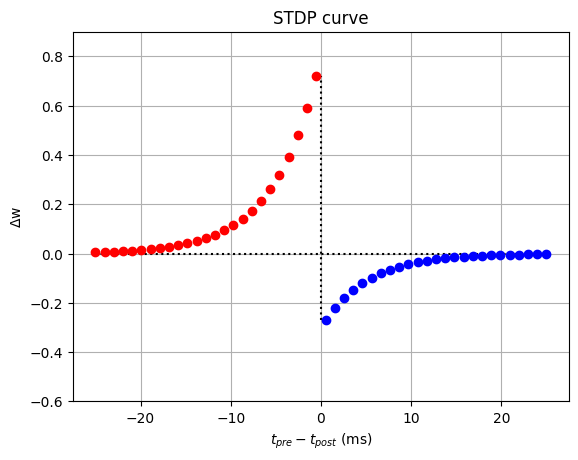

In [ ]:
s.plot_stdp_curve()

## Random Testing

Loading Parameters
Loading Raw Data


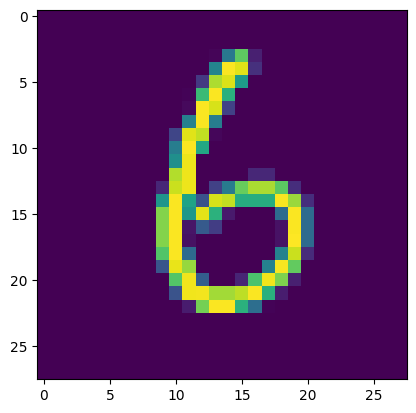

Label=6
True
6.0


In [ ]:
img,spike_train,lab = MNISTProcesser(Params()).dataloader(train=False,preprocess=True,random_single=True)
plt.imshow(img)
plt.show()
print(f"Label={lab}")

synapses = np.loadtxt(r'Good Values/81/synapses.csv', delimiter=",")
neuron_label_map = np.loadtxt(r'Good Values/81/labels.csv', delimiter=',')
pred = s.get_prediction(spike_train,synapses,neuron_label_map)
print(lab == pred)
print(pred)

In [ ]:
def accura():
    spike_trains,labels = MNISTProcesser(Params()).dataloader(train=False,preprocess=True,seed=563,size=2000)
    synapses = np.loadtxt(r'Good Values/81/synapses.csv', delimiter=",")
    neuron_label_map = np.loadtxt(r'Good Values/81/labels.csv', delimiter=',')
    t = 0
    c = 0
    preds = []
    print('Calculating Accuracy')
    for st,label in zip(spike_trains,labels):
        pred = s.get_prediction(st,synapses,neuron_label_map)
        preds.append(pred)
        if pred == label:
            c+=1
        t+=1
        print(f"\rTested {t} images",end='')
    print()
    print(c/t)
    return labels,preds

y_true,y_pred = accura()


Loading Parameters
Loading Raw Data
Loading preprocessed test data
Calculating Accuracy
Tested 2000 images
0.7675


In [ ]:
def random_tester():
    return np.random.choice(range(0,10))

def random_accuracy(dataloader):
    c = 0
    t = 0
    for _,label in zip(*dataloader):
        t+=1
        if label == random_tester():
            c+=1
    return c/t

a = []
dataloader = MNISTProcesser(Params()).dataloader(train=False)
for _ in range(1000):
    a.append(random_accuracy(dataloader))
print(np.mean(a))


Loading Parameters
Loading Raw Data
Loading test data
0.09886000000000002


## Confusion Matrix for actual and predicted values

![](https://i.ibb.co/R02fn4G/download.png)

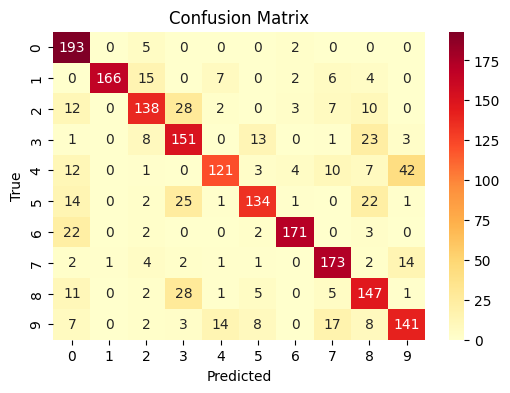

In [ ]:
def create_confusion_matrix(y_true, y_pred):
    y_true = list(np.array(y_true).astype(int))
    y_pred = list(np.array(y_pred).astype(int))
    unique_labels = np.unique(y_true + y_pred)
    num_classes = len(unique_labels)
    cm = np.zeros((num_classes, num_classes), dtype=int)
    label_to_index = {label: i for i, label in enumerate(unique_labels)}
    for true, pred in zip(y_true, y_pred):
        cm[label_to_index[true], label_to_index[pred]] += 1
    return cm, unique_labels

cm, labels = create_confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlOrRd", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## Visualising Learned synapses

In [ ]:
synapses = np.loadtxt(r'Good Values/81/synapses.csv', delimiter=",")
neuron_label_map = np.loadtxt(r'Good Values/81/labels.csv', delimiter=',')
p = Params()

Loading Parameters


In [ ]:
def get_image_from_synapse(synapse,min_weight,max_weight):
    return np.interp(synapse,[min_weight,max_weight],[0,255]).astype(int).reshape(28,28)
def group_indices_by_value(arr):
    unique_values = np.unique(arr)
    groups = {int(value): np.where(arr == i)[0] for i, value in enumerate(unique_values)}
    return groups

def show_label_time_frame(label,neuron_label_map,synapses,min_weight,max_weight):
    idx_ls = group_indices_by_value(neuron_label_map)[int(label)]
    imgs = np.array([get_image_from_synapse(synapses[i],min_weight,max_weight) for i in idx_ls])
    return np.mean(imgs,axis=0).astype(int)

### Final learned synapses visualised.

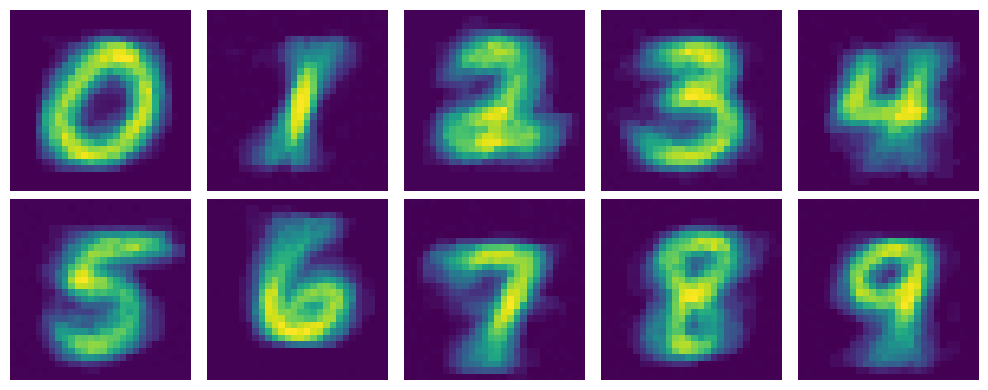

In [ ]:
imgs = [show_label_time_frame(i,neuron_label_map,synapses,p.min_weight,p.max_weight) for i in range(10)]
fig,axes = plt.subplots(2,5,figsize=(10,4))
for i, ax in enumerate(axes.flat):
    ax.imshow(imgs[i])
    ax.axis('off')
plt.tight_layout()
plt.show()

## Visualising Synapses through training time.

![](https://i.ibb.co/JFmPTZH/download.png)


In [ ]:
ls = []
for epoch in s.master_memory:
    dc = {i:[] for i in range(10)}
    for label,synapse in epoch:
        dc[label].append(synapse)
    ls.append(dc)

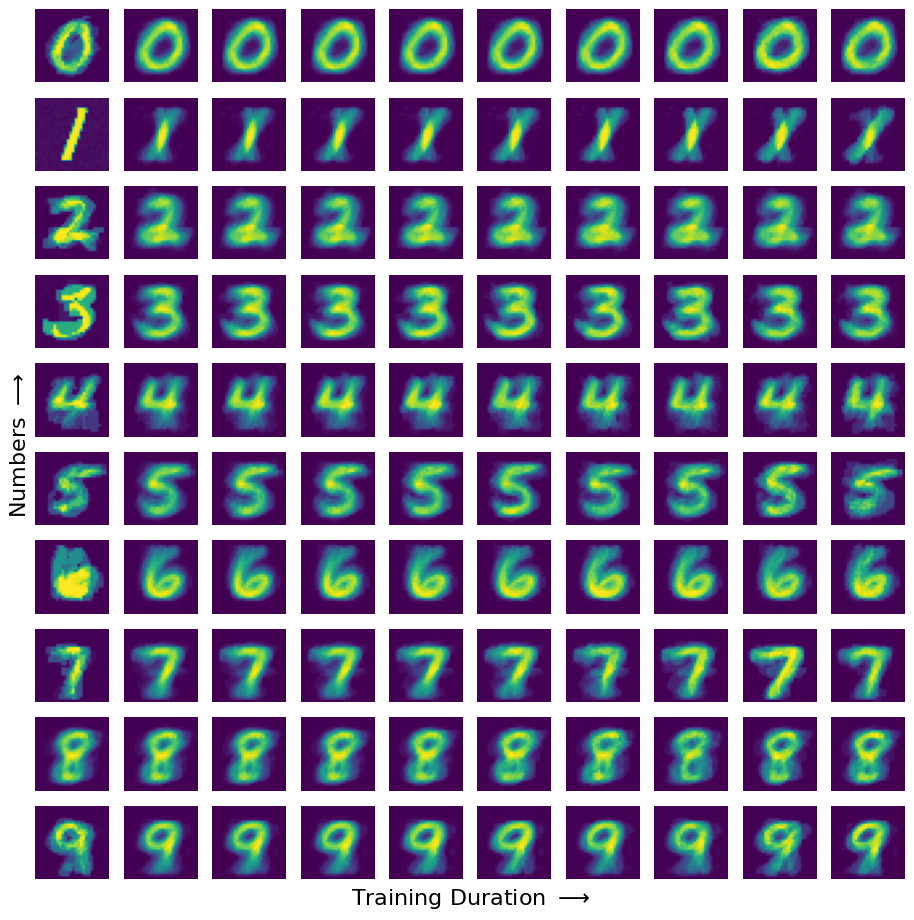

In [ ]:
# data = ls[1][4]
def get_synapse_learning(data):
    timestamp_map = defaultdict(list)
    mv = 1e8
    for sublist in data:
        for timestamp, image in sublist:
            timestamp_map[timestamp].append(np.array(image))
        mv = min(mv,len(sublist))

    result = {}
    for timestamp, images in timestamp_map.items():
        result[timestamp] = np.mean(images, axis=0).tolist()

    sorted_result = np.array([result[timestamp] for timestamp in sorted(result.keys())])
    idcs = np.arange(0,mv,mv//9).tolist()
    idcs[-1] = mv-1
    while len(idcs)!=10:
        idcs.append(mv-1)
    return sorted_result[idcs]

l2 = []
for i in ls[1].values():
    l2.append(get_synapse_learning(i))

flattened_images = [np.interp(img.reshape(28,28),[p.min_weight,p.max_weight],[0,255]).astype(int) for sublist in l2 for img in sublist]
fig, axes = plt.subplots(10, 10, figsize=(10, 10))  # Adjust figsize for better resolution

for i, ax in enumerate(axes.flat):
    ax.imshow(flattened_images[i])
    ax.axis('off')

fig.text(0.5, 0.04, r'Training Duration $\longrightarrow$', ha='center', fontsize=16)
fig.text(0.04, 0.5, r'Numbers $\longrightarrow$', va='center', rotation='vertical', fontsize=16)

plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
plt.show()
